# 1. Imports

In [1]:
import time
import numpy as np

In [5]:
import pandas as pd
import numpy as np
import random
import io
import os
import matplotlib.pyplot as plt
import polars as pl
from numba import jit
import time


# 2. Data Structure Design

Write a data structure that indexes the data (a) by user and (b) by movie



In [6]:
import os
import pickle
import numpy as np
import polars as pl
import pandas as pd

In [7]:
#  read the data to a POLARS dataframe
movies  = pl.read_csv('Data/ml-32m/movies.csv')
ratings = pl.read_csv('Data/ml-32m/ratings.csv')

In [8]:
grouped_users = ratings.group_by('userId', maintain_order=True).agg(pl.col('movieId'), pl.col('rating'))
grouped_movies= ratings.group_by('movieId', maintain_order=True).agg(pl.col('userId') , pl.col('rating'))

In [9]:
grouped_users,grouped_movies

(shape: (200_948, 3)
 ┌────────┬─────────────────────┬───────────────────┐
 │ userId ┆ movieId             ┆ rating            │
 │ ---    ┆ ---                 ┆ ---               │
 │ i64    ┆ list[i64]           ┆ list[f64]         │
 ╞════════╪═════════════════════╪═══════════════════╡
 │ 1      ┆ [17, 25, … 3088]    ┆ [4.0, 1.0, … 3.0] │
 │ 2      ┆ [31, 34, … 783]     ┆ [5.0, 5.0, … 5.0] │
 │ 3      ┆ [2, 10, … 7389]     ┆ [3.5, 4.0, … 0.5] │
 │ 4      ┆ [223, 1210, … 3203] ┆ [4.0, 3.0, … 1.0] │
 │ 5      ┆ [10, 47, … 595]     ┆ [4.0, 3.0, … 3.0] │
 │ …      ┆ …                   ┆ …                 │
 │ 200944 ┆ [1, 47, … 151345]   ┆ [4.0, 4.5, … 4.0] │
 │ 200945 ┆ [21, 32, … 183833]  ┆ [4.0, 5.0, … 0.5] │
 │ 200946 ┆ [6, 10, … 1073]     ┆ [4.0, 5.0, … 5.0] │
 │ 200947 ┆ [1, 110, … 164909]  ┆ [4.0, 4.5, … 4.5] │
 │ 200948 ┆ [1, 2, … 87304]     ┆ [5.0, 1.5, … 4.5] │
 └────────┴─────────────────────┴───────────────────┘,
 shape: (84_432, 3)
 ┌─────────┬────────────────────┬───────

In [10]:
user_idx_map = {user_id: idx for idx, user_id in enumerate(grouped_users['userId'].to_list())}
movie_idx_map = {movie_id: idx for idx, movie_id in enumerate(grouped_movies['movieId'].to_list())}

In [11]:
# Create inverse mapping for user indices
idx_to_user = {idx: user_id for user_id, idx in user_idx_map.items()}

# Create inverse mapping for movie indices
idx_to_movie = {idx: movie_id for movie_id, idx in movie_idx_map.items()}


In [12]:
# ######
def indexing_users(user_id):
    return user_idx_map[user_id]

def indexing_movies(movie_id):
    return movie_idx_map[movie_id]

In [13]:
ratings = ratings.with_columns([
    pl.col("userId").cast(pl.Int32),
    pl.col("movieId").cast(pl.Int32),
    pl.col("rating").cast(pl.Float32),
    pl.col("userId").map_elements(indexing_users, return_dtype = pl.Int32).alias("userIdx"),
    pl.col("movieId").map_elements(indexing_movies,return_dtype = pl.Int32).alias("movieIdx"),])
ratings.head(5)

/tmp/ipykernel_14362/4120979370.py:5: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("userId").map_elements(indexing_users)
with this one instead:
  + pl.col("userId").replace_strict(user_idx_map)

  pl.col("userId").map_elements(indexing_users, return_dtype = pl.Int32).alias("userIdx"),
/tmp/ipykernel_14362/4120979370.py:6: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("movieId").map_elements(indexing_movies)
with this one instead:
  + pl.col("movieId").replace_strict(movie_idx_map)

  pl.col("movieId").map_elements(indexing_movies,return_dtype = pl.Int32).alias("movieIdx"),])


userId,movieId,rating,timestamp,userIdx,movieIdx
i32,i32,f32,i64,i32,i32
1,17,4.0,944249077,0,0
1,25,1.0,944250228,0,1
1,29,2.0,943230976,0,2
1,30,5.0,944249077,0,3
1,32,5.0,943228858,0,4


In [ ]:
dff = ratings.with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32)
            .shuffle(seed=0)
            .gt(pl.len() * 0.2)
            .alias("split")
        ).partition_by("split", include_key=False)
dff

[shape: (25_600_163, 6)
 ┌────────┬─────────┬────────┬────────────┬─────────┬──────────┐
 │ userId ┆ movieId ┆ rating ┆ timestamp  ┆ userIdx ┆ movieIdx │
 │ ---    ┆ ---     ┆ ---    ┆ ---        ┆ ---     ┆ ---      │
 │ i32    ┆ i32     ┆ f32    ┆ i64        ┆ i32     ┆ i32      │
 ╞════════╪═════════╪════════╪════════════╪═════════╪══════════╡
 │ 1      ┆ 17      ┆ 4.0    ┆ 944249077  ┆ 0       ┆ 0        │
 │ 1      ┆ 25      ┆ 1.0    ┆ 944250228  ┆ 0       ┆ 1        │
 │ 1      ┆ 29      ┆ 2.0    ┆ 943230976  ┆ 0       ┆ 2        │
 │ 1      ┆ 30      ┆ 5.0    ┆ 944249077  ┆ 0       ┆ 3        │
 │ 1      ┆ 32      ┆ 5.0    ┆ 943228858  ┆ 0       ┆ 4        │
 │ …      ┆ …       ┆ …      ┆ …          ┆ …       ┆ …        │
 │ 200948 ┆ 79702   ┆ 4.5    ┆ 1294412589 ┆ 200947  ┆ 3084     │
 │ 200948 ┆ 79796   ┆ 1.0    ┆ 1287216292 ┆ 200947  ┆ 9169     │
 │ 200948 ┆ 80350   ┆ 0.5    ┆ 1294412671 ┆ 200947  ┆ 6133     │
 │ 200948 ┆ 80463   ┆ 3.5    ┆ 1350423800 ┆ 200947  ┆ 1105     │
 

In [14]:
def create_train_test_df(ratings):
    # The Data Structure
    grouped_users = ratings.group_by('userId', maintain_order=True).agg(pl.col('movieId'), pl.col('rating'))
    grouped_movies= ratings.group_by('movieId', maintain_order=True).agg(pl.col('userId') , pl.col('rating'))
    user_idx_map = {user_id: idx for idx, user_id in enumerate(grouped_users['userId'].to_list())}
    movie_idx_map = {movie_id: idx for idx, movie_id in enumerate(grouped_movies['movieId'].to_list())}
    del grouped_users , grouped_movies

    # Create inverse mapping for user indices
    idx_to_user = {idx: user_id for user_id, idx in user_idx_map.items()}

    # Create inverse mapping for movie indices
    idx_to_movie = {idx: movie_id for movie_id, idx in movie_idx_map.items()}

    def indexing_users(user_id):
        return user_idx_map[user_id]

    def indexing_movies(movie_id):
        return movie_idx_map[movie_id]

    # Add a column using a custom function
    ratings = ratings.with_columns([
        pl.col("userId").cast(pl.Int32),
        pl.col("movieId").cast(pl.Int32),
        pl.col("rating").cast(pl.Float32),
        pl.col("userId").map_elements(indexing_users, return_dtype = pl.Int32).alias("userIdx"),
        pl.col("movieId").map_elements(indexing_movies,return_dtype = pl.Int32).alias("movieIdx"),])


    # method 2 - very good
    def train_test_split_df(df, seed=0, test_size=0.2):
        return df.with_columns(
            pl.int_range(pl.len(), dtype=pl.UInt32)
            .shuffle(seed=seed)
            .gt(pl.len() * test_size)
            .alias("split")
        ).partition_by("split", include_key=False)


    def train_test_split(X,seed=0, test_size=0.1):
        (X_train, X_test) = train_test_split_df(X, seed=seed, test_size=test_size)
        return (X_train, X_test)

    train_df,test_df = train_test_split(ratings)
    return  train_df,test_df,user_idx_map,  movie_idx_map ,idx_to_user, idx_to_movie

def split(dataframe):

  grouped_users = dataframe.group_by('userIdx', maintain_order=True).agg(pl.col('movieIdx'), pl.col('rating'))
  users_data = grouped_users[:,1:].to_numpy()
  user_indices = grouped_users[:,0].to_numpy()

  grouped_movies= dataframe.group_by('movieIdx', maintain_order=True).agg(pl.col('userIdx') , pl.col('rating'))
  movies_data = grouped_movies[:,1:].to_numpy()
  movies_indices = grouped_movies[:,0].to_numpy()

  return users_data,user_indices,movies_data,movies_indices


In [15]:
train_df, test_df, user_idx_map, movie_idx_map,idx_to_user,idx_to_movie  =  create_train_test_df(ratings)

In [17]:

def save_idx_maps(experiment_folder,user_idx_map,  movie_idx_map ,idx_to_user,idx_to_movie,genre_to_idx,genre_to_movies):
    # Create the directory if it doesn't exist
    os.makedirs(experiment_folder, exist_ok=True)

    # Save the dictionaries
    with open(os.path.join(experiment_folder, 'user_idx_map.pkl'), 'wb') as f:
        pickle.dump(user_idx_map, f)

    with open(os.path.join(experiment_folder, 'movie_idx_map.pkl'), 'wb') as f:
        pickle.dump(movie_idx_map, f)

    with open(os.path.join(experiment_folder, 'idx_to_user.pkl'), 'wb') as f:
        pickle.dump(idx_to_user, f)

    with open(os.path.join(experiment_folder, 'idx_to_movie.pkl'), 'wb') as f:
        pickle.dump(idx_to_movie, f)

    with open(os.path.join(experiment_folder, 'genre_to_idx.pkl'), 'wb') as f:
        pickle.dump(genre_to_idx, f)

    with open(os.path.join(experiment_folder, 'genre_to_movies.pkl'), 'wb') as f:
        pickle.dump(genre_to_movies, f)
    print("Dictionaries saved successfully!")

def Save_data_split(experiment_folder,users_train,users_test,users_test_idxes,movies_test_idxes,users_train_idxes,movies_train_idxes,movies_train,movies_test,movies_genres_array):

    os.makedirs(experiment_folder, exist_ok=True)

    np.save(f'./{experiment_folder}/users_train.npy', users_train,allow_pickle=True)
    np.save(f'./{experiment_folder}/users_test.npy', users_test,allow_pickle=True)

    np.save(f'./{experiment_folder}/users_test_idxes.npy', users_test_idxes,allow_pickle=True)
    np.save(f'./{experiment_folder}/movies_test_idxes.npy', movies_test_idxes,allow_pickle=True)

    np.save(f'./{experiment_folder}/users_train_idxes.npy', users_train_idxes,allow_pickle=True)
    np.save(f'./{experiment_folder}/movies_train_idxes.npy', movies_train_idxes,allow_pickle=True)

    np.save(f'./{experiment_folder}/movies_train.npy', movies_train,allow_pickle=True)
    np.save(f'./{experiment_folder}/movies_test.npy', movies_test,allow_pickle=True)

    np.save(f'./{experiment_folder}/movies_genres_array.npy', movies_genres_array,allow_pickle=True)


In [18]:
users_data_train,user_indices,movies_data_train,movies_indices = split(train_df)

In [20]:
# Create the necessary DataStructures
train_df,test_df,user_idx_map,movie_idx_map ,idx_to_user, idx_to_movie = create_train_test_df(ratings)
users_test,users_test_idxes,movies_test,movies_test_idxes = split(test_df)
users_train,users_train_idxes,movies_train,movies_train_idxes = split(train_df)

# Basic Data Structure

In [23]:
class MovieLookups():
  def __init__(self,ratings):
    self.ratings = ratings

    self.user_idx_map      = {}
    self.idx_user_map      = []
    self.Users_idxed_list  = []

    self.movie_idx_map     = {}
    self.idx_movie_map     = []
    self.movies_idxed_list = []

    self.ratings['userId']  = self.ratings['userId'].astype('int32')
    self.ratings['movieId'] = self.ratings['movieId'].astype('int32')
    self.ratings['rating']  = self.ratings['rating'].astype('float32')

  def create_lookups(self):
      for user_id,movie_id,rating in zip(self.ratings['userId'], self.ratings['movieId'] , self.ratings['rating']):
      # FOR THE USERS
        user_idx = self.user_idx_map.setdefault(user_id, len(self.idx_user_map))   # check if id exist and return it, if not , set it to len(idx_user_map)
        if user_idx == len(self.idx_user_map):                                    # if user is already there, no loop, if its new, enter the loop
          self.idx_user_map.append(user_idx)                                      # add that user to the index to user map
          self.Users_idxed_list.append([])                                     # create an empty list inside the big list for this user

      # FOR THE MOVIES
        movie_idx = self.movie_idx_map.setdefault(movie_id, len(self.idx_movie_map))
        if movie_idx == len(self.idx_movie_map):
            self.idx_movie_map.append(movie_idx)
            self.movies_idxed_list.append([])

     # Fill the respective lists
        # self.Users_idxed_list[user_idx].sort()
        self.Users_idxed_list[user_idx].append((movie_idx,rating))
        # self.movies_idxed_list[movie_idx].sort()
        self.movies_idxed_list[movie_idx].append((user_idx,rating))
      return (self.Users_idxed_list , self.movies_idxed_list)

  def get_movies_rated_by_user(self,user_id):
    person_ID = self.user_to_idx[user_id]
    return self.Users_idxed_list[person_ID]
# Data_processing
  def get_users_who_rated_movie(self,movie_id):
    movie_ID = self.movie_idx_map[movie_id]
    return self.movies_idxed_list[movie_ID]

  def get_movie_degree(self,movie_id):
    return len(self.get_users_who_rated_movie(movie_id))

  def get_user_degree(self,user_id):
    return len(self.get_movies_rated_by_user(user_id))

#  defining the split function
  def Users_split(self):
      users_train_data = []
      users_val_data   = []
      # Split data for each user
      for user_idx, user_data in enumerate(self.Users_idxed_list):
        #  get the length of this user's list of movies
          num_ratings = len(user_data)
          # prepare a placeholder for this user
          users_train_data.append([])
          users_val_data.append([])
          for data_tuple in user_data:
            p = random.random()
            if p > 0.9 :
              # print( user_idx , user_data, users_train_data[user_idx],type( users_train_data[user_idx]))
              # users_train_data[user_idx].append(())
              users_val_data[user_idx].append(data_tuple)
            else:
              users_train_data[user_idx].append(data_tuple)
              # users_val_data[user_idx].append(())
      return users_train_data, users_val_data

  def Movies_split(self):
      movies_train_data = []
      movies_val_data = []

      # Split data for each user
      for movie_idx, movie_data in enumerate(self.movies_idxed_list):
        #  get the keng of this user's list of movies
          # prepare a placeholder for this user
          movies_train_data.append([])
          movies_val_data.append([])
          for data_tuple in movie_data:
            p = random.random()
            if p > 0.9 :
              # print( user_idx , user_data, movies_train_data[user_idx],type( movies_train_data[user_idx]))
              # movies_train_data[movie_idx].append(())
              movies_val_data[movie_idx].append(data_tuple)
            else:
              movies_train_data[movie_idx].append(data_tuple)
              # movies_val_data[movie_idx].append(())
      return movies_train_data, movies_val_data


# plotting the loss and the RMSE curves
def plot_likelihood(x_axis, y_axis ):
  plt.figure(figsize=(10, 6))
  plt.subplot(1,2,1)
  plt.plot(range(x_axis) , y_axis[0])
  # plt.title('Training Likelihood Curve')
  plt.xlabel('Iterations')
  plt.ylabel('loss')
  plt.subplot(1,2,2)
  plt.plot(range(x_axis) , y_axis[1] , c ='r')
  # plt.title('Validation Likelihood Curve')
  plt.xlabel('Iterations')
  plt.ylabel('loss')
  plt.savefig('Training& Validation Likelihood Curves.pdf')
  plt.show()


# Movie degrees
def plot_rmse(x_axis,y_axis):
  plt.figure(figsize=(10, 6))
  # plt.subplot(1,2,1)
  plt.plot(range(x_axis) , y_axis[0])
  # plt.title('Training RMSE Curve')
  plt.xlabel('Iterations')
  plt.ylabel('RMSE')
  # plt.subplot(1,2,2)
  plt.plot(range(x_axis) , y_axis[1] , c ='r')
  # plt.title('Validation RMSE Curve')
  plt.xlabel('Iterations')
  plt.ylabel('RMSE')
  plt.savefig('Training & Validation RMSE Curves.pdf')

  plt.show()
  

## Testing the DS

In [26]:
#  write some tests here
# Create an instance of the data structure
#  read the data to a POLARS dataframe
movies  = pd.read_csv('Data/ml-32m/movies.csv')
ratings = pd.read_csv('Data/ml-32m/ratings.csv')
import time
tic = time.time()

# Initialize the MovieLookups class
movie_lookups = MovieLookups(ratings)

# Build the mappings
movie_lookups.create_lookups()

tac = time.time()
print(tac-tic)
# takes around 1.5 minutes

16.481253385543823


In [ ]:
ll = movie_lookups.Users_idxed_list
l2 = movie_lookups.movies_idxed_list
n_users = len(ll) ; n_movies= len(l2)
print(f"The Total number of movies is {n_movies} \n and the total number of Users is {n_users}")

The Total number of movies is 84432 
 and the total number of Users is 200948


# 3. Exploratory Data Analysis

Plot rating distributions of data | Power Law Patterns in The Data


In [30]:
# the degree of a user is how many movies did that user rate (watch) i.e the length of the list corresponding to that user
user_degrees = [len(movie_list) for movie_list in movie_lookups.Users_idxed_list]

#  Degree or popularity, the degree of a movie is basically how many users rated that movie i.e the length of the list corresponding to that movie
movie_degrees = [len(user_list) for user_list in movie_lookups.movies_idxed_list]

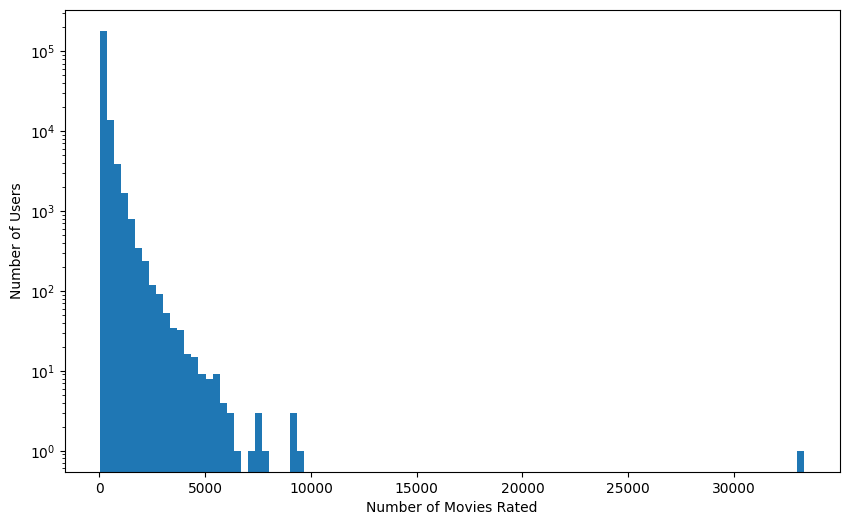

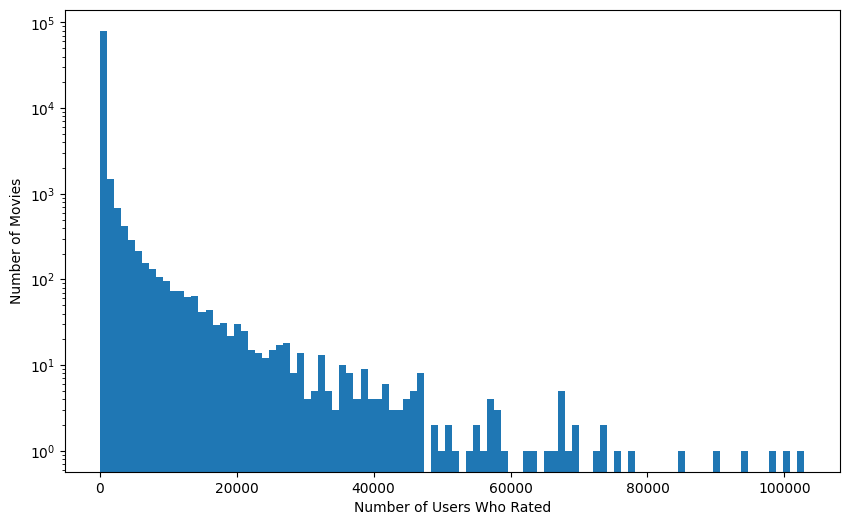

In [32]:
# Plot histogram for user degrees
plt.figure(figsize=(10, 6))
plt.hist(user_degrees, bins=100, log=True)
# plt.title('Histogram of User Degrees (Number of Movies Rated per User)')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number of Users')
plt.savefig('User_Degrees.pdf')
# plt.savefig('User_Degrees.svg')
plt.show()


# Plot histogram for movie degrees
plt.figure(figsize=(10, 6))
plt.hist(movie_degrees, bins=100, log=True)
# plt.title('Histogram of Movie Degrees (Number of Use/rs per Movie)')
plt.xlabel('Number of Users Who Rated')
plt.ylabel('Number of Movies')
plt.savefig('Movies_Degrees.pdf')
plt.show()


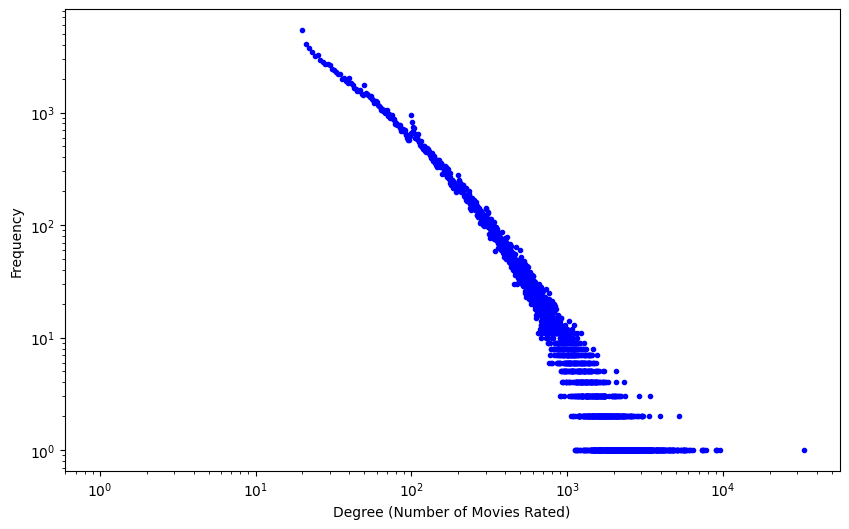

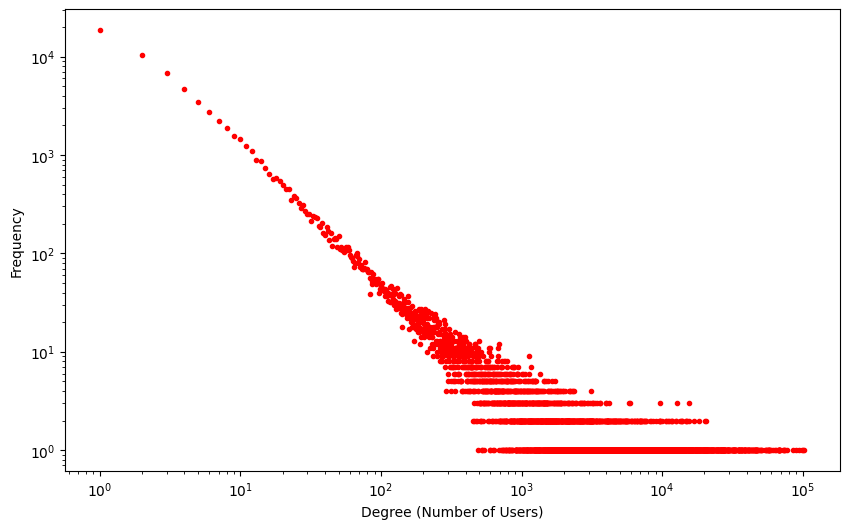

In [33]:
# User degrees
degree_counts_user = np.bincount(user_degrees)
degrees_user = np.arange(len(degree_counts_user))

plt.figure(figsize=(10, 6))
plt.loglog(degrees_user[1:], degree_counts_user[1:], 'b.')
# plt.title('User Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (Number of Movies Rated)')
plt.ylabel('Frequency')
plt.savefig('User_Degree_Distribution_(Log-Log_Scale).pdf')

plt.show()

# Movie degrees
degree_counts_movie = np.bincount(movie_degrees)
degrees_movie = np.arange(len(degree_counts_movie))

plt.figure(figsize=(10, 6))
plt.loglog(degrees_movie[1:], degree_counts_movie[1:], 'r.')
# plt.title('Movie Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (Number of Users)')
plt.ylabel('Frequency')
plt.savefig('Movie_Degree_Distribution_(Log-Log_Scale).pdf')
plt.show()

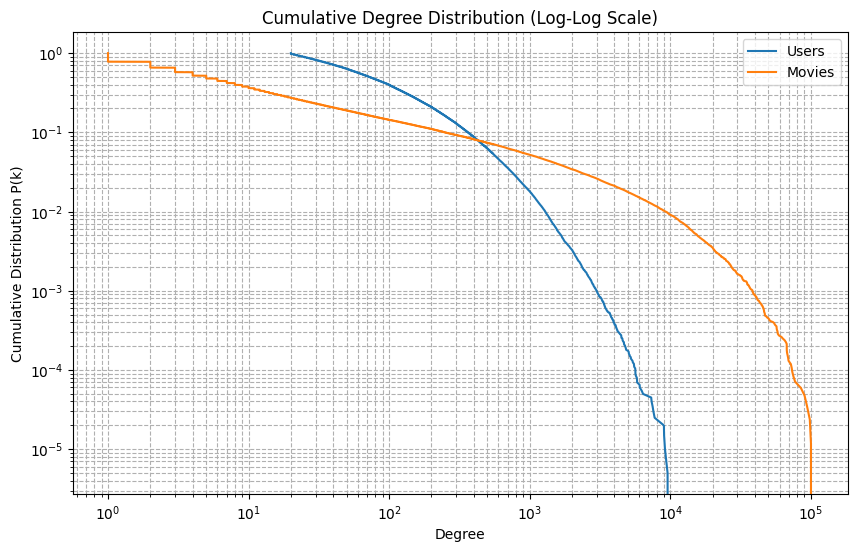

In [34]:
def plot_cumulative_degree_distribution(degrees, label):
    # Sort degrees in ascending order
    sorted_degrees = np.sort(degrees)
    # Get the cumulative distribution: the fraction of nodes with degree >= k
    cumulative_distribution = 1.0 - np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)

    # Plotting the cumulative degree distribution
    plt.plot(sorted_degrees, cumulative_distribution, label=label)

# Plot the cumulative distribution for users and movies
plt.figure(figsize=(10, 6))
plot_cumulative_degree_distribution(user_degrees, 'Users')
plot_cumulative_degree_distribution(movie_degrees, 'Movies')

# Setting log-log scale
plt.xscale('log')
plt.yscale('log')

# Adding labels and title
plt.xlabel('Degree')
plt.ylabel('Cumulative Distribution P(k)')
plt.title('Cumulative Degree Distribution (Log-Log Scale)')
plt.legend()
plt.grid(True, which="both", ls="--")

# Show the plot
plt.show()



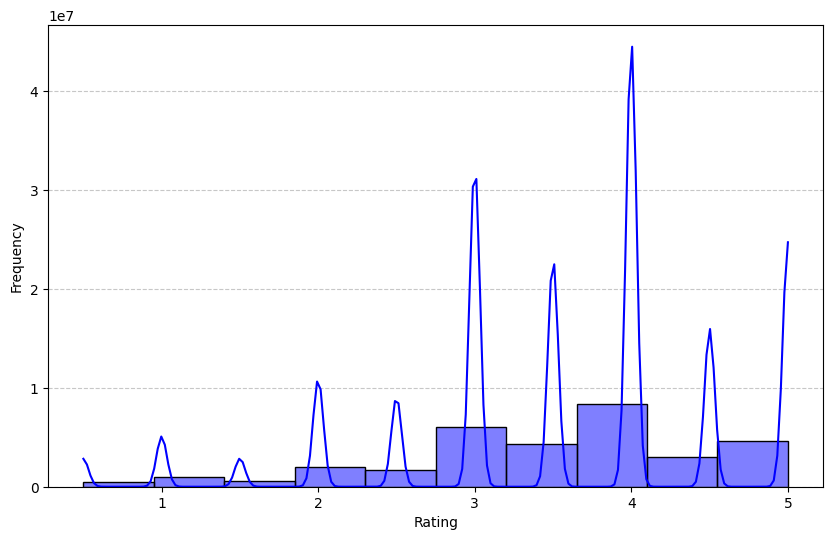

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rating_distribution(ratings):
    # Plotting the distribution of ratings
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings['rating'], bins=10, kde=True, color='blue')  # kde=True adds a smooth curve
    # plt.title('Distribution of Movie Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('Distribution_of_Movie_Ratings.pdf')

    plt.show()

# Call the function with your ratings DataFrame
plot_rating_distribution(movie_lookups.ratings)

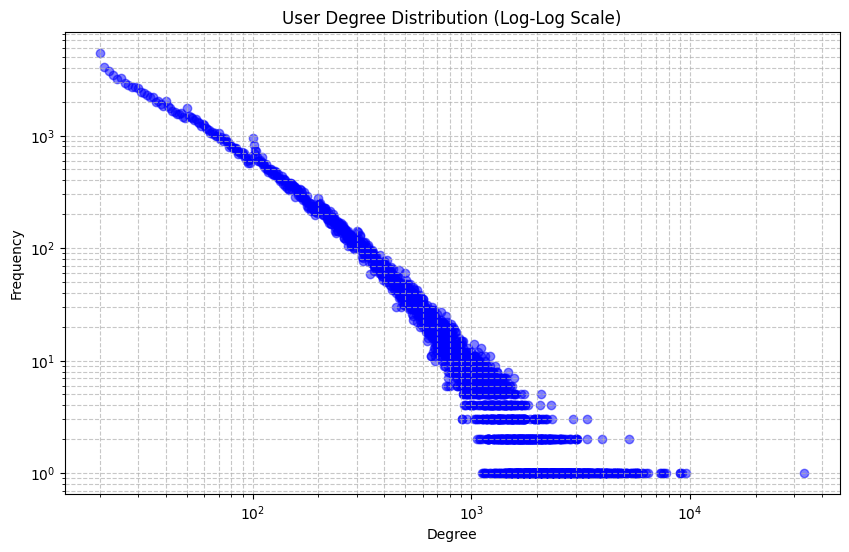

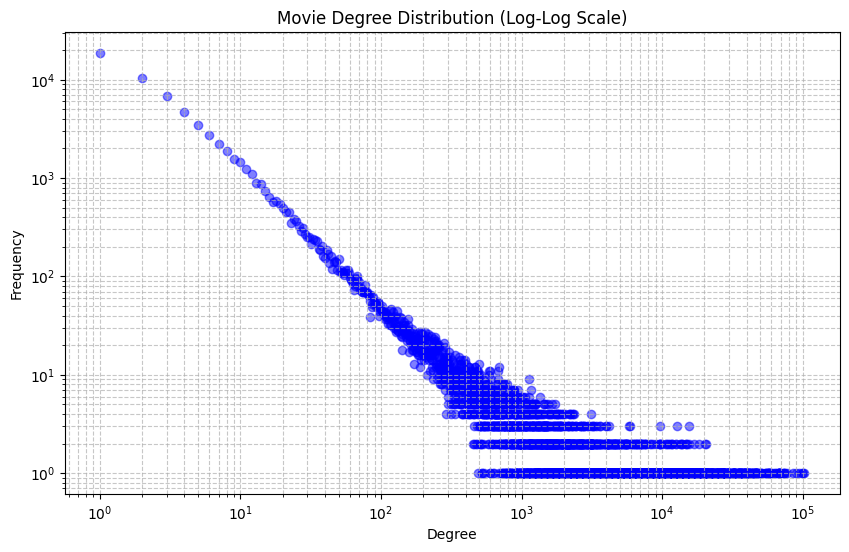

Power-law exponent for movies: 1.4518008639416056
R value: 247135.06725013678, p value: 0.0 (Comparing power law vs. exponential)


In [38]:
from collections import Counter
import powerlaw

def plot_degree_distribution(degrees, title):
    # Plotting the degree distribution on a log-log scale
    degree_counts = Counter(degrees)
    x, y = zip(*degree_counts.items())
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5, color='blue')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.show()

# Calculate the degree distributions
user_degrees = [len(movie_list) for movie_list in movie_lookups.Users_idxed_list]
movie_degrees = [len(user_list) for user_list in movie_lookups.movies_idxed_list]

# Plot the degree distributions
plot_degree_distribution(user_degrees, 'User Degree Distribution (Log-Log Scale)')
plot_degree_distribution(movie_degrees, 'Movie Degree Distribution (Log-Log Scale)')

# Optional: Fit power-law to the movie degrees using the powerlaw library
fit = powerlaw.Fit(movie_degrees, xmin=1)  # xmin=1 to include all degrees
print(f'Power-law exponent for movies: {fit.power_law.alpha}')
R, p = fit.distribution_compare('power_law', 'exponential')
print(f'R value: {R}, p value: {p} (Comparing power law vs. exponential)')


# joint density

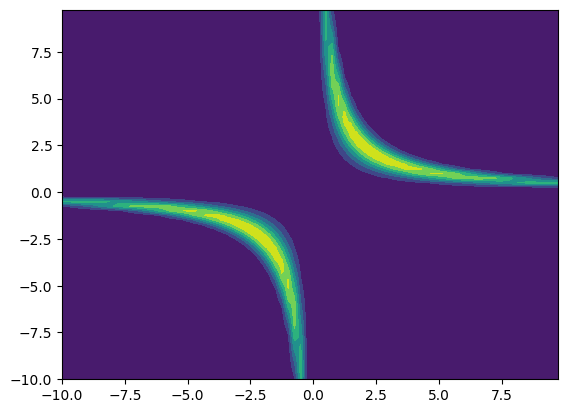

In [28]:
import math
pi = math.pi
def plot_density(r ,tau ,lambda_ ):
  u = np.arange(-10,10 , 0.25)
  v = np.arange(-10, 10 , 0.25)
  U,V = np.meshgrid(u,v)

  density  = np.sqrt(lambda_/2*pi) * (tau/2*pi) *  np.exp(-0.5 * lambda_*(r - U*V)**2  - 0.5* tau *(U**2 + V**2))
  plt.contourf(u,v,density)
plot_density(r = 5,tau = 0.01, lambda_ = 0.5)
